# Signal-to-noise ratio analysis for auditory attention

In [384]:
from __future__ import division, print_function

import matplotlib.pyplot as plt

from joblib import Parallel, delayed, dump
from itertools import product
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from scipy.stats import iqr

import os

In [385]:
# load data
def load_data(filename):
    # load dataset
    exames_dict = loadmat(filename)
    
    target = 1*(exames_dict['target']==2) # atencao esquerda igual a 1
    exames = exames_dict['exams']

    target = np.squeeze(target)
    exames = np.squeeze(exames)
    return exames, target


def load_base(filename):
    # load base data
    base_dict = loadmat(filename)
    
    base = base_dict['base_exams']
    base = np.squeeze(base)
    return base


def filt_data(data, order, fs, f1, f2, band):
    nyq = 0.5*fs  # nyquist frequency

    a1,b1 = butter(order,[(f1-(band/2))/nyq,(f1+(band/2))/nyq],btype='bandpass')
    a2,b2 = butter(order,[(f2-(band/2))/nyq,(f2+(band/2))/nyq],btype='bandpass')

    dataf1 = filtfilt(a1,b1,data,axis=1)
    dataf2 = filtfilt(a2,b2,data,axis=1)

    return dataf1, dataf2

In [386]:
# STARTING ANALYSIS

path = "/home/pedrosergiot/Documents/"
exames, target = load_data(path + 'exames_sem1segundo_novo.mat')
basal = load_base(path + 'base_exames_sem1segundo.mat')

# data parameters
fs = 601.5  # sampling rate
f1 = 39.36  # modulating frequency 1 (right ear)
f2 = 31.13  # modulating frequency 2 (left ear)

filter_band = 0.4
#filter_band = 2.0
filter_order = 4

exames_1 = exames[target==0,:,:]   # exames orelha 1 (direita)
exames_2 = exames[target==1,:,:]   # exames orelha 2 (esquerda)

f1_exames1, f2_exames1 = filt_data(exames_1, filter_order, fs, f1, f2, filter_band)
f1_exames2, f2_exames2 = filt_data(exames_2, filter_order, fs, f1, f2, filter_band)
f1_basal, f2_basal = filt_data(basal, filter_order, fs, f1, f2, filter_band)

# Using original signal

The procedure here consists into divinding the signal into windows (different window sizes tested) and calculate the SNR as described in Bozzi's Thesis. Each window is considered an experiment of a stochastic process, with the variance estimated for each time point (random variable). The mean of these variance is calculated and used in the SNR's equation (process realized for both the obtained signal and the noise signal)

In [357]:
win_sizes = np.array([64,86,128,172,344,688,1376,2752])

num_wins = np.array(exames_1.shape[1]/win_sizes, dtype=int)

results_snr1 = {}
results_snr2 = {}

for ind_winsize in range(0,len(win_sizes)):
    
    winsize = win_sizes[ind_winsize]
    
    exames1_wins = []
    exames2_wins = []
    basal_wins = []
    
    # Cutting the windows and saving them in a new list
    for ind_win in range(0,num_wins[ind_winsize]):
        
        exames1_wins.append(exames_1[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        exames2_wins.append(exames_2[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basal_wins.append(basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
                
    # Transforming the lists into arrays to better deal with them
    # shape of these arrays: (num_windows, num_exams, num_timepoints, num_electrodes)
    exames1_wins = np.array(exames1_wins)
    exames2_wins = np.array(exames2_wins)
    basal_wins = np.array(basal_wins)
    
    # variance estimation for each random variable of the stochastic process (each point in the window)
    # New shape: (num_exams, num_timepoints, num electrodes)
    var_exames1 = np.var(exames1_wins, axis=0)
    var_exames2 = np.var(exames2_wins, axis=0)
    var_basal = np.var(basal_wins, axis=0)
    
    # SNR calculation (SNR = avg(var(signal))/avg(var(noise)) - 1)
    # Two cases: exams for right and left attention
    # New shape: (num_exams, num_electroes)
    # Each point in the array is the SNR for a given electrode of an specific exam
    snr1 = (np.mean(var_exames1, axis=1)/np.mean(var_basal, axis=1)) - 1
    snr2 = (np.mean(var_exames2, axis=1)/np.mean(var_basal, axis=1)) - 1
    
    # Saving results using the window size as the key
    results_snr1[winsize] = snr1
    results_snr2[winsize] = snr2

In [377]:
# just a draft for checking shapes and negative SNRs
print(exames1_wins.shape)
print(var_exames1.shape)
print(results_snr1[64].shape)
print(np.sum(results_snr1[64] <= 0, axis=0)) # accounts how many exams with SNR <=0 existed per electrode
print(np.sum(results_snr1[64] <= 0, axis=1)) # accounts how many electrodes with SNR <=0 existed per exam

(1, 144, 5504, 19)
(144, 2752, 19)
(144, 19)
[75 73 62 99 72 62 64 64 71 63 68 94 69 65 66 59 69 76 68]
[ 6  9  4 10  2 19 15 15  2  6 19 12  1 10  2 14 19  2  2 14  3  6  2 11
  2 15  0  3 15 10  6 18 17  0 14 15 19  2  1 10  8 13 18 16 18 11 18  5
 12  7 17 17  6  7  2 13  4  6  6 10  4 15 18  5  2 16  0  1  5  8  7  3
 14 15 10 16  4  9 10 13 14 11 13  7  7 14 10  1 19 16 12  8  8  9  4  3
 11  3 13 19  7 10  3  6 19  2 10 15  5 10  2  1  9 16  0 19  4 16  9 17
 19  6  2 11 15 16 14 16  2  1 17  2  1  9  3  2 19 12 16  7  0 13  6  7]


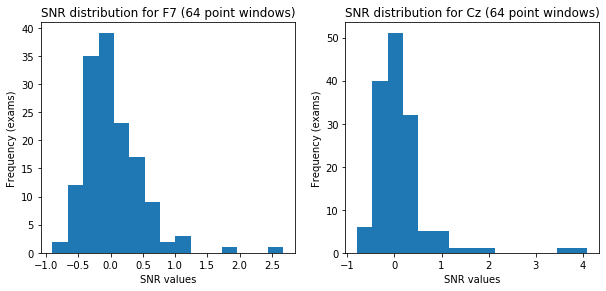

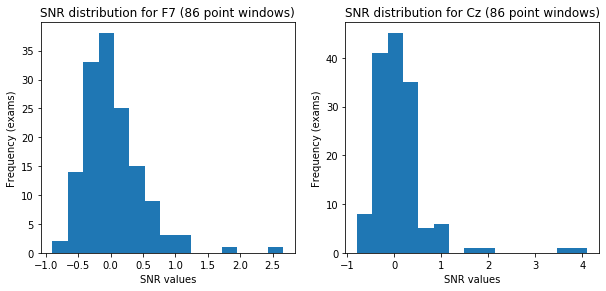

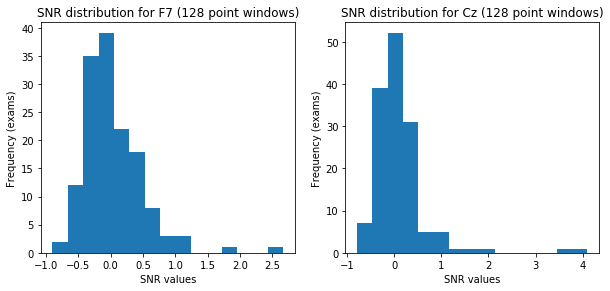

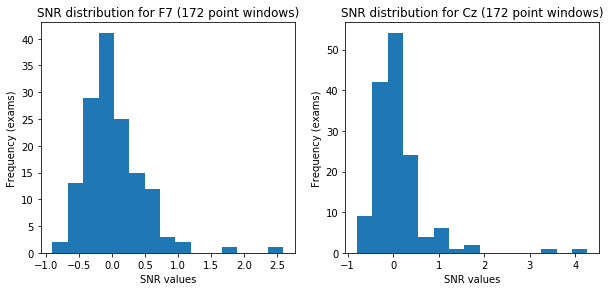

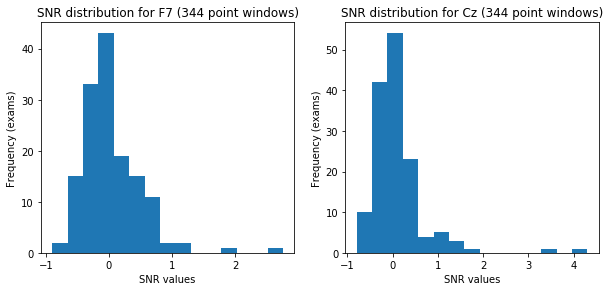

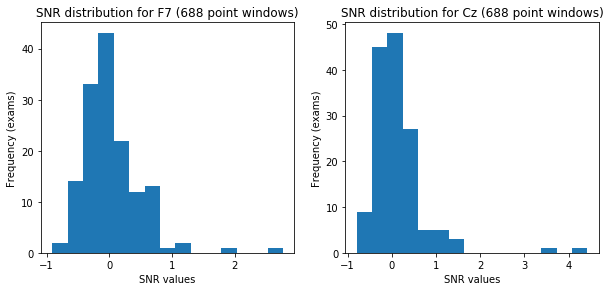

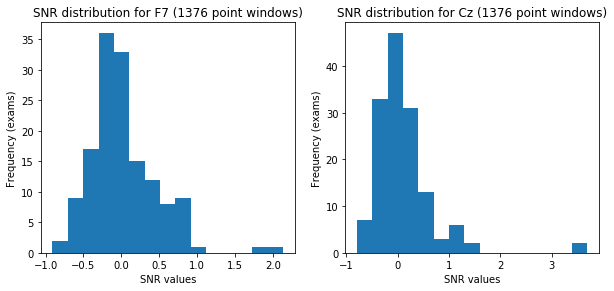

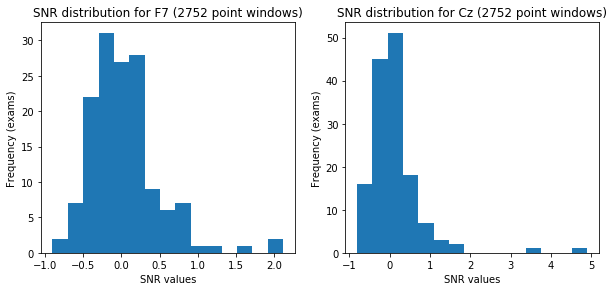

In [358]:
# Plotting the distributions of SNR for some electrodes
# Frequency shows how many exams presented the values of SNR determined by the bins
# This shows an import problem: for some EEGs, the energy of the obtained signal was lower than the noise signal

for key in win_sizes:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    #fig1,ax1 = plt.subplots(figsize=(7,7))
    ax1.hist(results_snr1[key][:,0], bins=15);
    ax1.set_title('SNR distribution for F7 (' + str(key) + ' point windows)');
    ax1.set_ylabel('Frequency (exams)');
    ax1.set_xlabel('SNR values');

    #fig2,ax2 = plt.subplots(figsize=(7,7))
    ax2.hist(results_snr1[key][:,18], bins=15);
    ax2.set_title('SNR distribution for Cz (' + str(key) + ' point windows)');
    ax2.set_ylabel('Frequency (exams)');
    ax2.set_xlabel('SNR values');

    plt.subplots_adjust(left = 0.125,  # the left side of the subplots of the figure
                        right = 0.9,   # the right side of the subplots of the figure
                        bottom = 0.1,  # the bottom of the subplots of the figure
                        top = 0.9,     # the top of the subplots of the figure
                        wspace = 0.2,  # the amount of width reserved for space between subplots,
                        hspace = 0.8,)

As shown above, we face a problem with negative SNR for some cases which does not make sense in practice. The problem seems to arise due the attention signal having less energy than the base signal. To check this, we have a look if the energy in the windows of the obtained signals is higher than the energy of the corresponding windows for the noise signal

In [366]:
# Comparing energies
win_sizes = np.array([64,86,128,172,344,688,1376,2752,5504])

num_wins = np.array(exames_1.shape[1]/win_sizes, dtype=int)

ratio1 = {}  # energy ratio attention1/base
ratio2 = {}  # energy ratio attention2/base

for ind_winsize in range(0,len(win_sizes)):
    
    winsize = win_sizes[ind_winsize]
    
    exames1_wins = []
    exames2_wins = []
    basal_wins = []
    
    # Cutting the windows and saving them in a new list
    for ind_win in range(0,num_wins[ind_winsize]):
        
        exames1_wins.append(exames_1[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        exames2_wins.append(exames_2[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basal_wins.append(basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
                
    # Transforming the lists into arrays to better deal with them
    exames1_wins = np.array(exames1_wins)
    exames2_wins = np.array(exames2_wins)
    basal_wins = np.array(basal_wins)
    
    # Energy calculation for each window (Energy = sum(signal.^2))
    energ_exames1 = np.sum(np.square(exames1_wins), axis=2)
    energ_exames2 = np.sum(np.square(exames2_wins), axis=2)
    energ_basal = np.sum(np.square(basal_wins), axis=2)
    
    # Energy ratio for each side of attention
    energ_ratio1 = energ_exames1/energ_basal
    energ_ratio2 = energ_exames2/energ_basal
    
    # Transforming ratio arrays into shape like (num_windows, channels)
    for ind in range(0,energ_ratio1.shape[0]):
        if ind == 0:
            temp_ratio1 = energ_ratio1[ind,:,:]
            temp_ratio2 = energ_ratio2[ind,:,:]
            energ_new1 = energ_exames1[ind,:,:]
            energ_new2 = energ_exames2[ind,:,:]
            energ_basal_new = energ_basal[ind,:,:]
        else:
            temp_ratio1 = np.concatenate((temp_ratio1, energ_ratio1[ind,:,:]), axis=0)
            temp_ratio2 = np.concatenate((temp_ratio2, energ_ratio2[ind,:,:]), axis=0)
            energ_new1 = np.concatenate((energ_new1, energ_exames1[ind,:,:]), axis=0)
            energ_new2 = np.concatenate((energ_new2, energ_exames2[ind,:,:]), axis=0)
            energ_basal_new = np.concatenate((energ_basal_new, energ_basal[ind,:,:]), axis=0)
            
    # Histograms for energy values of all windows (one for each window size value)
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
    #ax1.hist(energ_new1[:,0], bins=20);
    #ax2.hist(energ_new2[:,0], bins=20);
    #ax3.hist(energ_basal_new[:,0], bins=20);
    
    print(winsize)
    print((np.min(energ_new1[:,0]), np.max(energ_new1[:,0]), np.mean(energ_new1[:,0])))
    print((np.min(energ_new2[:,0]), np.max(energ_new2[:,0]), np.mean(energ_new2[:,0])))
    print((np.min(energ_basal_new[:,0]), np.max(energ_basal_new[:,0]), np.mean(energ_basal_new[:,0])))
    
    # Saving results
    ratio1[winsize] = temp_ratio1
    ratio2[winsize] = temp_ratio2

64
(47.55321281117301, 1366157.9371188884, 4369.395842086993)
(26.525654852631135, 90352340.39820972, 47270.420505173395)
(3.157489904840908, 2181000.833694802, 5144.089582446073)
86
(66.92577184972592, 1682750.4029307058, 5871.375662804397)
(61.1514217185372, 144249921.3292952, 63519.62755382675)
(3.736763892067692, 3065840.0174953234, 6912.370376411911)
128
(212.01234938396794, 1903788.9703234846, 8738.791684173986)
(183.5022010170364, 145964242.90254816, 94540.84101034678)
(10.715428566510505, 3698705.44624672, 10288.179164892146)
172
(269.41093541918247, 2345932.2649285495, 11742.751325608793)
(267.76600352694186, 153465557.08961356, 127039.25510765349)
(15.775811135544817, 4044104.546254693, 13824.740752823822)
344
(847.088515514959, 3077429.64068229, 23485.502651217594)
(847.7602596527377, 169699738.2980066, 254078.51021530697)
(241.18166380202368, 6735078.444024909, 27649.481505647644)
688
(2051.701568499849, 4766627.684552426, 46971.00530243517)
(2155.2767458501444, 179550209.0

In [375]:
from scipy.stats import iqr

IQR1 = iqr(ratio1[64], axis=0)
IQR2 = iqr(ratio2[64], axis=0)

Q1_ratio1 = np.quantile(ratio1[64], .25, axis=0)
Q3_ratio1 = np.quantile(ratio1[64], .75, axis=0)
Q1_ratio2 = np.quantile(ratio2[64], .25, axis=0)
Q3_ratio2 = np.quantile(ratio2[64], .75, axis=0)

k = 1.5

ind1_no_outlier = np.logical_and((ratio1[64] >= Q1_ratio1 - k*IQR1),(ratio1[64] <= Q3_ratio1 + k*IQR1))
print(ind1_no_outlier.shape)
np.sum(np.sum(ind1_no_outlier, axis=1)==19)

print(np.max(ratio1[64][ind1_no_outlier[:,18],0]))
print(Q3_ratio1)

(12384, 19)
555.6964538500923
[2.11310491 2.13994444 2.1799528  1.98995707 2.1869966  2.20705527
 2.13727679 2.18392937 2.30444181 2.24136186 2.21367548 2.02074243
 2.26481163 2.30304875 2.19635305 2.09988563 2.18832296 2.20339698
 2.16288339]


Distributions without outliers (removed by IQR)
-> Considering all windows for all exams


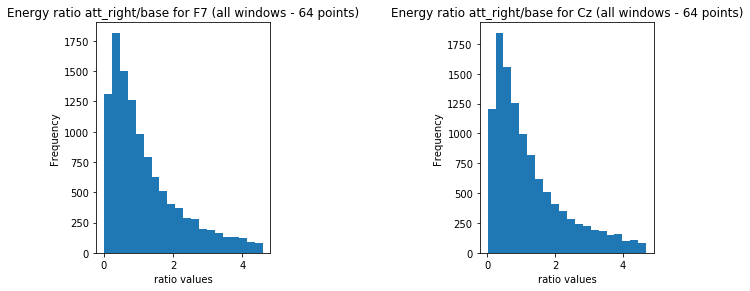

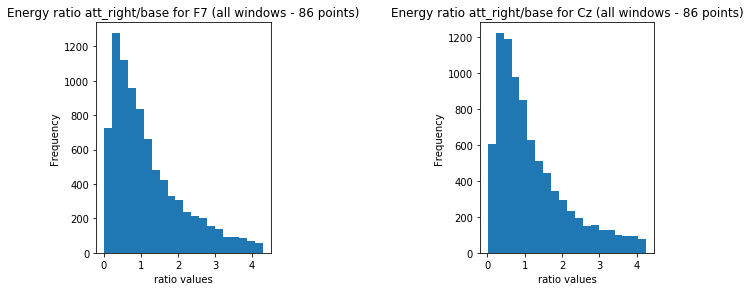

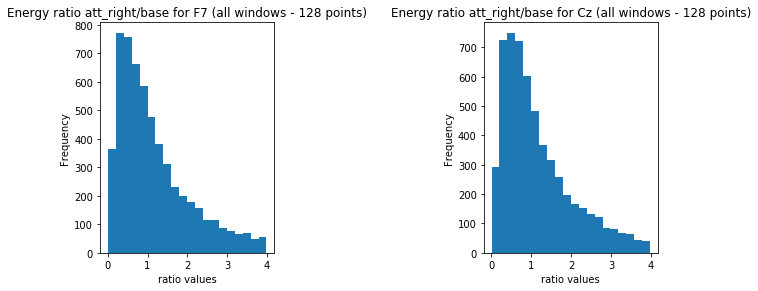

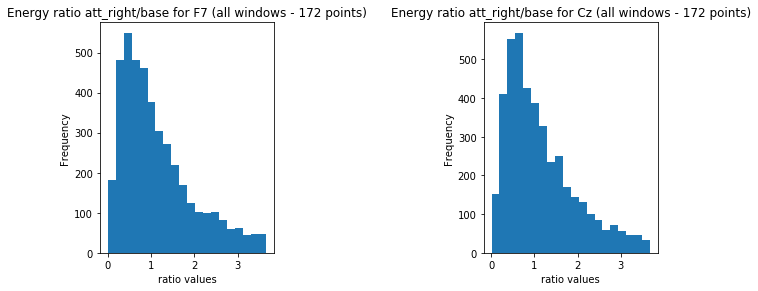

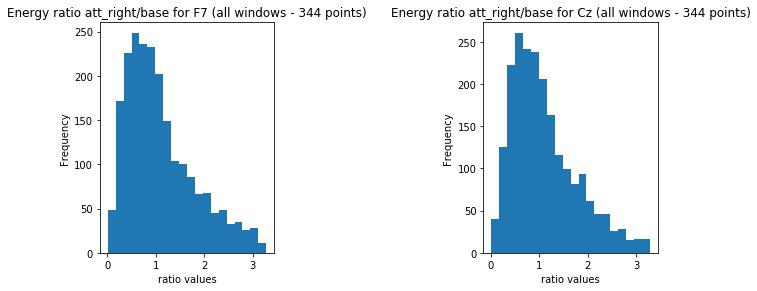

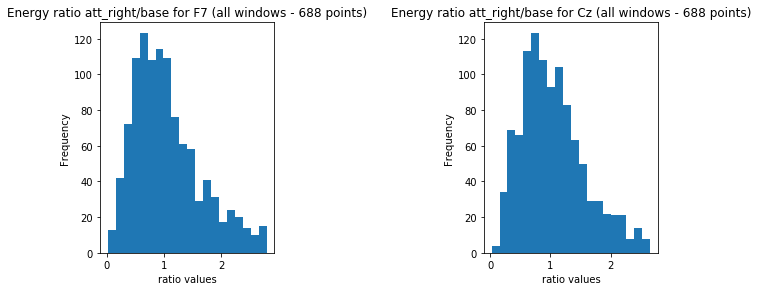

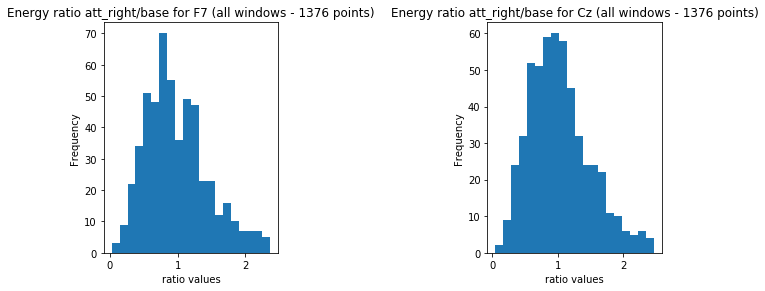

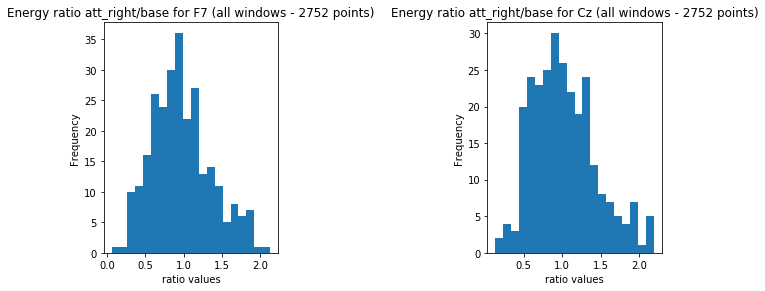

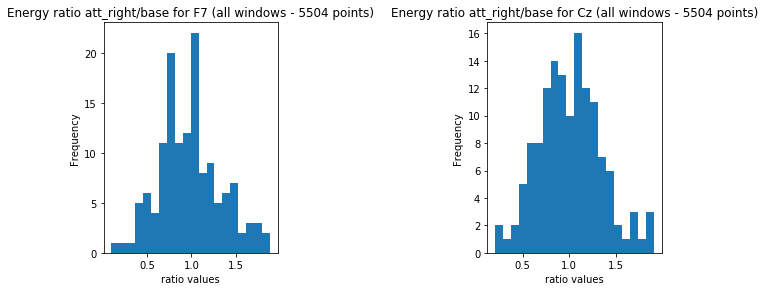

In [380]:
# Following histograms show the dist for the ratio (num windows where energy_exams > energy_base)/total_windows
# Are considered some electrodes for all exams, with frequency indicating the number of exams (max 144) which
# presented the specified ratio indicated by the bins on the horizontal axis

print('Distributions without outliers (removed by IQR)')
print('-> Considering all windows for all exams')

for key in win_sizes:
    
    # Removing possible outliers
    IQR1 = iqr(ratio1[key], axis=0)

    Q1_ratio1 = np.quantile(ratio1[key], .25, axis=0)
    Q3_ratio1 = np.quantile(ratio1[key], .75, axis=0)

    k = 1.5

    ind1_no_outlier = np.logical_and((ratio1[key] >= Q1_ratio1 - k*IQR1),(ratio1[key] <= Q3_ratio1 + k*IQR1))
    
    # Plotting 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.hist(ratio1[key][ind1_no_outlier[:,0],0], bins=20);
    ax1.set_title('Energy ratio att_right/base for F7 (all windows - ' + str(key) + ' points)');
    ax1.set_ylabel('Frequency');
    ax1.set_xlabel('ratio values');

    #fig2,ax2 = plt.subplots(figsize=(7,7))
    ax2.hist(ratio1[key][ind1_no_outlier[:,18],18], bins=20);
    ax2.set_title('Energy ratio att_right/base for Cz (all windows - ' + str(key) + ' points)');
    ax2.set_ylabel('Frequency');
    ax2.set_xlabel('ratio values');

    plt.subplots_adjust(left = 0.125,  # the left side of the subplots of the figure
                        right = 0.9,   # the right side of the subplots of the figure
                        bottom = 0.1,  # the bottom of the subplots of the figure
                        top = 0.9,     # the top of the subplots of the figure
                        wspace = 1.2,  # the amount of width reserved for space between subplots,
                        hspace = 0.8,)

In [197]:
eletrodos = ['F7','T3','T5','Fp1','F3','C3','P3','O1','F8','T4','T6','Fp2','F4','C4','P4','O2','Fz','Cz','Pz']

# Using all exams
for key in win_sizes:
    
    snr1 = 10*np.log10(np.mean(results_snr1[key], axis=0))
    #snr1 = 10*np.log10(np.mean(results_snr1_mod, axis=0))
    prop_var1 = 10*np.std(results_snr1[key], axis=0)/(np.mean(results_snr1[key], axis=0)*np.log(10))
    #prop_var1 = 10*np.std(results_snr1_mod, axis=0)/(np.mean(results_snr1_mod, axis=0)*np.log(10))
    
    snr2 = 10*np.log10(np.mean(results_snr2[key], axis=0))
    #snr2 = 10*np.log10(np.mean(results_snr2_mod, axis=0))
    prop_var2 = 10*np.std(results_snr2[key], axis=0)/(np.mean(results_snr2[key], axis=0)*np.log(10))
    #prop_var2 = 10*np.std(results_snr2_mod, axis=0)/(np.mean(results_snr2_mod, axis=0)*np.log(10))

        
    ind_electrodes = np.argsort(-snr1)
    electrodes_order = [eletrodos[i] for i in ind_electrodes[0:7]]
    
    print('Window size: ' + str(key))
    print(snr1[ind_electrodes[0:5]])
    print(prop_var1[ind_electrodes[0:5]])
    print(electrodes_order)
    print('\n')
    

Window size: 64
[-6.21962476 -6.27125004 -7.34162963 -7.67533771 -8.26777282]
[13.93710059 19.2549418  13.47573705 17.4380446  19.59768635]
['T4', 'O1', 'C4', 'T6', 'T3', 'O2', 'P4']


Window size: 86
[-6.19814576 -6.21413247 -7.35335013 -7.68806635 -8.29753427]
[13.91137583 19.11672082 13.5728864  17.50342326 26.24797306]
['T4', 'O1', 'C4', 'T6', 'O2', 'T3', 'P4']


Window size: 128
[-6.18506615 -6.25068313 -7.34145831 -7.65715612 -8.21690281]
[13.88872135 19.30639055 13.47819605 17.46169046 26.24657805]
['T4', 'O1', 'C4', 'T6', 'O2', 'T3', 'P4']


Window size: 172
[-6.15041147 -6.24234774 -7.24115317 -7.77674463 -8.28854271]
[13.90583168 19.28229959 13.61221041 17.60985728 19.61869304]
['T4', 'O1', 'C4', 'T6', 'T3', 'P4', 'O2']


Window size: 344
[-6.13929783 -6.2238945  -7.13650126 -7.75187159 -8.30939669]
[14.01940568 19.1465539  13.76175209 17.96815424 19.77395617]
['T4', 'O1', 'C4', 'T6', 'T3', 'O2', 'P4']


Window size: 688
[-6.10564191 -6.13623158 -7.20251668 -7.62577372 -8.284

/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


# Using filtered signal

Here is shown the same procedure done above, now using both signals filtered in the frequencies of interest

In [273]:
win_sizes = np.array([64,86,128,172,344,688,1376,2752])

num_wins = np.array(f1_exames1.shape[1]/win_sizes, dtype=int)

results_snr1 = {}
results_snr2 = {}

for ind_winsize in range(0,len(win_sizes)):
    
    winsize = win_sizes[ind_winsize]
    
    exames1_wins = []
    exames2_wins = []
    basalf1_wins = []
    basalf2_wins = []
    
    # Cutting the windows and saving them in a new list
    for ind_win in range(0,num_wins[ind_winsize]):
        
        exames1_wins.append(f1_exames1[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        exames2_wins.append(f2_exames2[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basalf1_wins.append(f1_basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basalf2_wins.append(f2_basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
                
    # Transforming the lists into arrays to better deal with them
    exames1_wins = np.array(exames1_wins)
    exames2_wins = np.array(exames2_wins)
    basalf1_wins = np.array(basalf1_wins)
    basalf2_wins = np.array(basalf2_wins)
    
    # SNR calculation (SNR = var(signal)/var(noise) - 1)
    # The variance for each point is calculated using all windows and then averaged for all points
    var_exames1 = np.var(exames1_wins, axis=0)
    var_exames2 = np.var(exames2_wins, axis=0)
    var_basalf1 = np.var(basalf1_wins, axis=0)
    var_basalf2 = np.var(basalf2_wins, axis=0)
    
    # Two cases: exams for right and left attention
    snr1 = (np.mean(var_exames1, axis=1)/np.mean(var_basalf1, axis=1)) - 1
    snr2 = (np.mean(var_exames2, axis=1)/np.mean(var_basalf2, axis=1)) - 1
    
    # Saving results
    results_snr1[winsize] = snr1
    results_snr2[winsize] = snr2

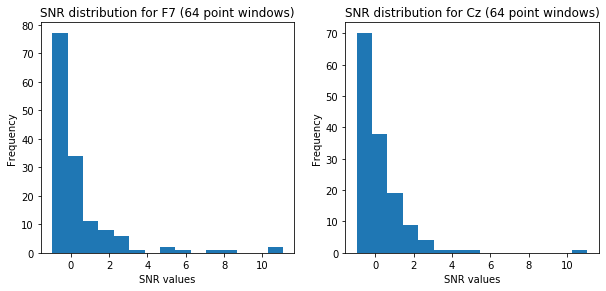

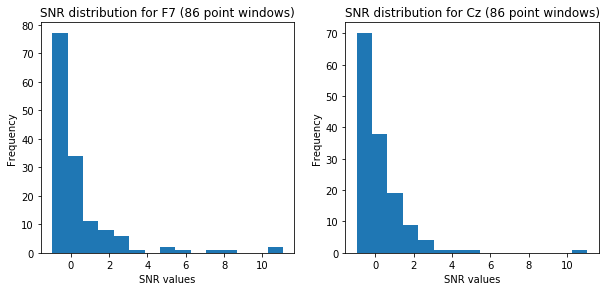

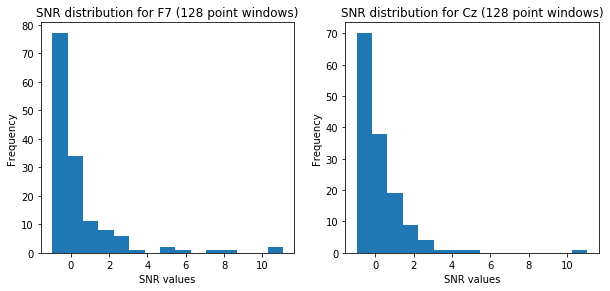

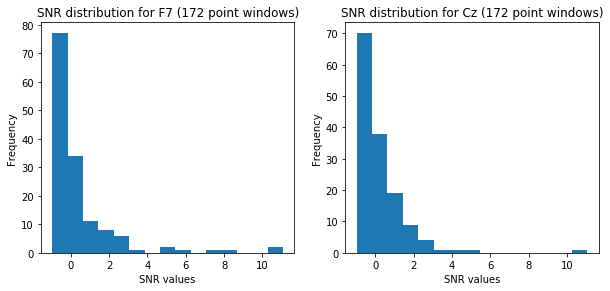

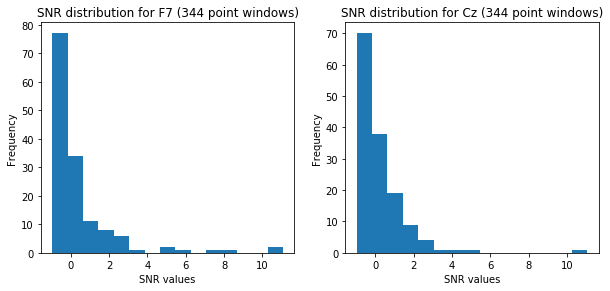

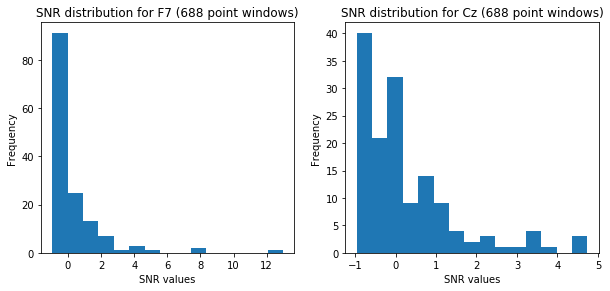

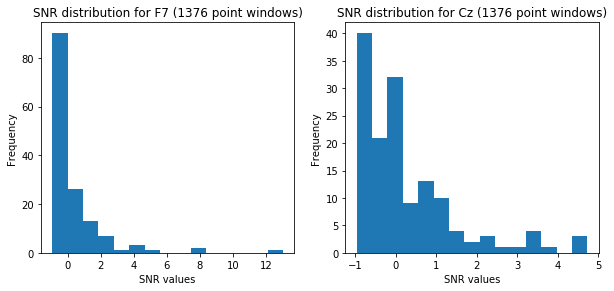

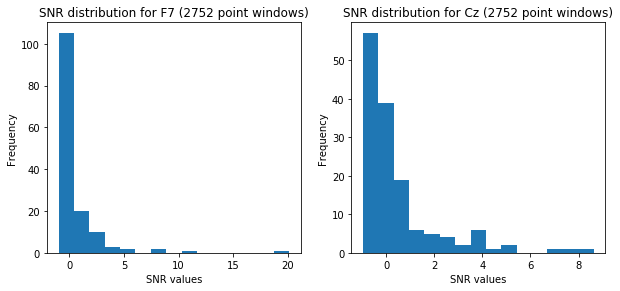

In [274]:
# Plotting the distributions of SNR for some electrodes
# Frequency shows how many exams presented the values of SNR determined by the bins
# This shows an import problem: for some EEGs, the energy of the obtained signal was lower than the noise signal

for key in win_sizes:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    #fig1,ax1 = plt.subplots(figsize=(7,7))
    ax1.hist(results_snr1[key][:,0], bins=15);
    ax1.set_title('SNR distribution for F7 (' + str(key) + ' point windows)');
    ax1.set_ylabel('Frequency');
    ax1.set_xlabel('SNR values');

    #fig2,ax2 = plt.subplots(figsize=(7,7))
    ax2.hist(results_snr1[key][:,18], bins=15);
    ax2.set_title('SNR distribution for Cz (' + str(key) + ' point windows)');
    ax2.set_ylabel('Frequency');
    ax2.set_xlabel('SNR values');

    plt.subplots_adjust(left = 0.125,  # the left side of the subplots of the figure
                        right = 0.9,   # the right side of the subplots of the figure
                        bottom = 0.1,  # the bottom of the subplots of the figure
                        top = 0.9,     # the top of the subplots of the figure
                        wspace = 0.2,  # the amount of width reserved for space between subplots,
                        hspace = 0.8,)

In [382]:
# Comparing energies
win_sizes = np.array([64,86,128,172,344,688,1376,2752,5504])

num_wins = np.array(exames_1.shape[1]/win_sizes, dtype=int)

ratio1 = {}  # energy ratio attention1/base
ratio2 = {}  # energy ratio attention2/base

for ind_winsize in range(0,len(win_sizes)):
    
    winsize = win_sizes[ind_winsize]
    
    exames1_wins = []
    exames2_wins = []
    basalf1_wins = []
    basalf2_wins = []
    
    # Cutting the windows and saving them in a new list
    for ind_win in range(0,num_wins[ind_winsize]):
        
        exames1_wins.append(f1_exames1[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        exames2_wins.append(f2_exames2[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basalf1_wins.append(f1_basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        basalf2_wins.append(f2_basal[:,ind_win*winsize:(ind_win*winsize)+winsize,:])
        
    # Transforming the lists into arrays to better deal with them
    exames1_wins = np.array(exames1_wins)
    exames2_wins = np.array(exames2_wins)
    basalf1_wins = np.array(basalf1_wins)
    basalf2_wins = np.array(basalf2_wins)
    
    # Energy calculation for each window (Energy = sum(signal.^2))
    energ_exames1 = np.sum(np.square(exames1_wins), axis=2)
    energ_exames2 = np.sum(np.square(exames2_wins), axis=2)
    energ_basalf1 = np.sum(np.square(basalf1_wins), axis=2)
    energ_basalf2 = np.sum(np.square(basalf2_wins), axis=2)
    
    # Energy ratio for each side of attention
    energ_ratio1 = energ_exames1/energ_basalf1
    energ_ratio2 = energ_exames2/energ_basalf2
    
    # Transforming ratio arrays into shape like (num_windows, channels)
    for ind in range(0,energ_ratio1.shape[0]):
        if ind == 0:
            temp_ratio1 = energ_ratio1[ind,:,:]
            temp_ratio2 = energ_ratio2[ind,:,:]
        else:
            temp_ratio1 = np.concatenate((temp_ratio1, energ_ratio1[ind,:,:]), axis=0)
            temp_ratio2 = np.concatenate((temp_ratio2, energ_ratio2[ind,:,:]), axis=0)
            
    # Saving results
    ratio1[winsize] = temp_ratio1
    ratio2[winsize] = temp_ratio2

Distributions without outliers (removed by IQR)
-> Considering all windows for all exams


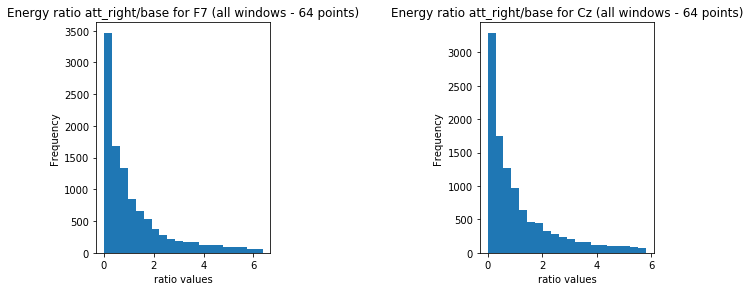

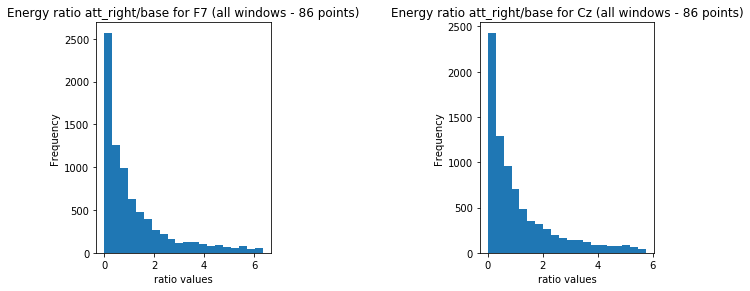

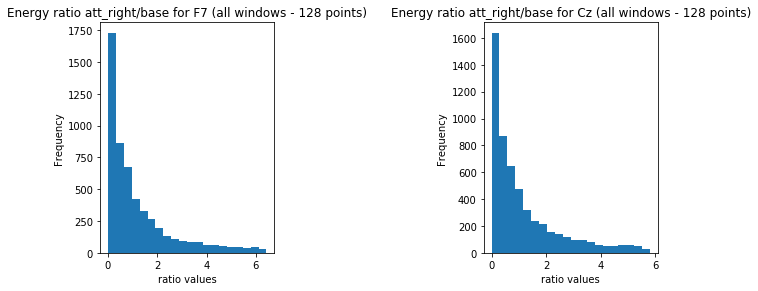

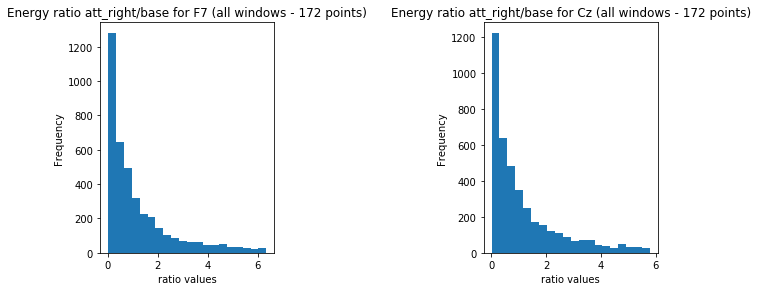

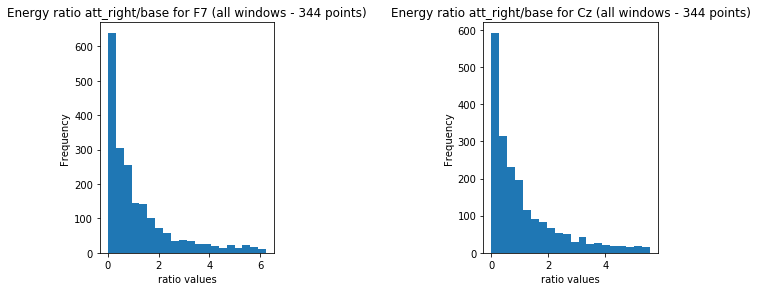

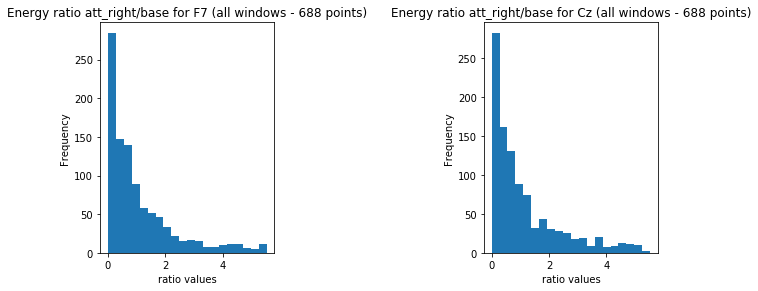

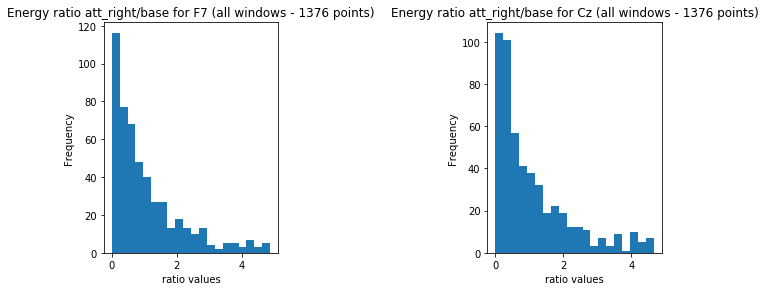

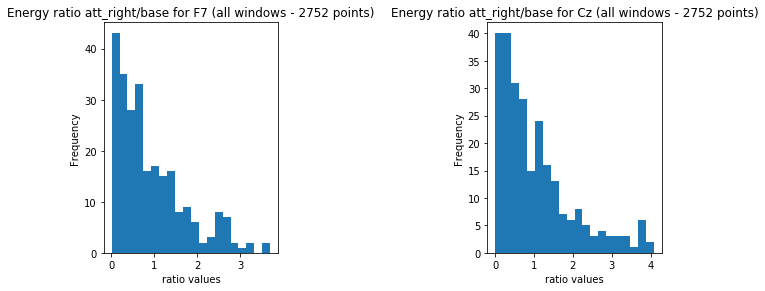

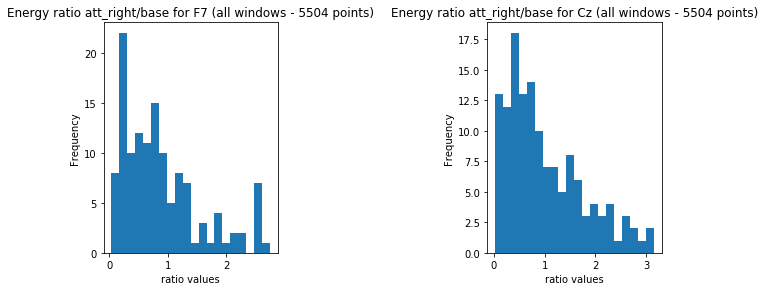

In [383]:
# Following histograms show the dist for the ratio (num windows where energy_exams > energy_base)/total_windows
# Are considered some electrodes for all exams, with frequency indicating the number of exams (max 144) which
# presented the specified ratio indicated by the bins on the horizontal axis

print('Distributions without outliers (removed by IQR)')
print('-> Considering all windows for all exams')
print('-> Filtered exams for right attention (38 Hz)')

for key in win_sizes:
    
    # Removing possible outliers
    IQR1 = iqr(ratio1[key], axis=0)

    Q1_ratio1 = np.quantile(ratio1[key], .25, axis=0)
    Q3_ratio1 = np.quantile(ratio1[key], .75, axis=0)

    k = 1.5

    ind1_no_outlier = np.logical_and((ratio1[key] >= Q1_ratio1 - k*IQR1),(ratio1[key] <= Q3_ratio1 + k*IQR1))
    
    # Plotting 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.hist(ratio1[key][ind1_no_outlier[:,0],0], bins=20);
    ax1.set_title('Energy ratio att_right/base for F7 (all windows - ' + str(key) + ' points)');
    ax1.set_ylabel('Frequency');
    ax1.set_xlabel('ratio values');

    #fig2,ax2 = plt.subplots(figsize=(7,7))
    ax2.hist(ratio1[key][ind1_no_outlier[:,18],18], bins=20);
    ax2.set_title('Energy ratio att_right/base for Cz (all windows - ' + str(key) + ' points)');
    ax2.set_ylabel('Frequency');
    ax2.set_xlabel('ratio values');

    plt.subplots_adjust(left = 0.125,  # the left side of the subplots of the figure
                        right = 0.9,   # the right side of the subplots of the figure
                        bottom = 0.1,  # the bottom of the subplots of the figure
                        top = 0.9,     # the top of the subplots of the figure
                        wspace = 1.2,  # the amount of width reserved for space between subplots,
                        hspace = 0.8,)